In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns; sns.set()

In [3]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix

In [4]:
data_attack = pd.read_csv('/content/drive/MyDrive/Dataset/attack.csv', nrows = 50000)

In [5]:
data_normal = pd.read_csv('/content/drive/MyDrive/Dataset/normal.csv', nrows = 50000)

In [6]:
data_normal.columns

Index(['frame.encap_type', 'frame.len', 'frame.protocols', 'ip.hdr_len',
       'ip.len', 'ip.flags.rb', 'ip.flags.df', 'p.flags.mf', 'ip.frag_offset',
       'ip.ttl', 'ip.proto', 'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
       'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
       'tcp.time_delta'],
      dtype='object')

In [7]:
data_normal[0:10]

,frame.encap_type,frame.len,frame.protocols,ip.hdr_len,ip.len,ip.flags.rb,ip.flags.df,p.flags.mf,ip.frag_offset,ip.ttl,ip.proto,ip.src,ip.dst,tcp.srcport,tcp.dstport,tcp.len,tcp.ack,tcp.flags.res,tcp.flags.ns,tcp.flags.cwr,tcp.flags.ecn,tcp.flags.urg,tcp.flags.ack,tcp.flags.push,tcp.flags.reset,tcp.flags.syn,tcp.flags.fin,tcp.window_size,tcp.time_delta
1,206,eth:ethertype:ip:tcp:ssh,20,192,0,1,0,0,128,6,192.168.1.101,192.168.5.122,4175,22,152,1,0,0,0,0,0,1,1,0,0,0,16697,0.000000,normal
1,60,eth:ethertype:ip:tcp,20,40,0,1,0,0,64,6,192.168.5.122,192.168.1.101,22,4175,0,153,0,0,0,0,0,1,0,0,0,0,7504,0.000537,normal
1,60,eth:ethertype:ip:tcp,20,40,0,1,0,0,63,6,192.168.5.122,192.168.1.101,22,4175,0,153,0,0,0,0,0,1,0,0,0,0,7504,0.000155,normal
1,774,eth:ethertype:ip:tcp:ssh,20,760,0,1,0,0,64,6,192.168.5.122,192.168.1.101,22,4175,720,153,0,0,0,0,0,1,1,0,0,0,7504,0.004483,normal
1,774,eth:ethertype:ip:tcp,20,760,0,1,0,0,63,6,192.168.5.122,192.168.1.101,22,4175,720,153,0,0,0,0,0,1,1,0,0,0,7504,0.001321,normal
1,1434,eth:ethertype:ip:tcp,20,1420,0,1,0,0,241,6,12.180.55.140,192.168.3.115,80,3816,1380,1,0,0,0,0,0,1,0,0,0,0,5189,0.000000,normal
1,66,eth:ethertype:ip:tcp,20,52,0,1,0,0,128,6,192.168.4.121,192.168.5.122,51061,22,0,0,0,0,0,0,0,0,0,0,1,0,8192,0.000000,normal
1,66,eth:ethertype:ip:tcp,20,52,0,1,0,0,64,6,192.168.5.122,192.168.4.121,22,51061,0,1,0,0,0,0,0,1,0,0,1,0,5840,0.000241,normal
1,66,eth:ethertype:ip:tcp,20,52,0,1,0,0,63,6,192.168.5.122,192.168.4.121,22,51061,0,1,0,0,0,0,0,1,0,0,1,0,5840,0.000132,normal
1,60,eth:ethertype:ip:tcp,20,40,0,1,0,0,128,6,192.168.4.121,192.168.5.122,51061,22,0,1,0,0,0,0,0,1,0,0,0,0,17520,0.000245,normal


In [8]:
data_normal.columns=[ 'frame.len', 'frame.protocols', 'ip.hdr_len',
       'ip.len', 'ip.flags.rb', 'ip.flags.df', 'p.flags.mf', 'ip.frag_offset',
       'ip.ttl', 'ip.proto', 'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
       'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
       'tcp.time_delta','class']
data_attack.columns=[ 'frame.len', 'frame.protocols', 'ip.hdr_len',
       'ip.len', 'ip.flags.rb', 'ip.flags.df', 'p.flags.mf', 'ip.frag_offset',
       'ip.ttl', 'ip.proto', 'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
       'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
       'tcp.time_delta','class']

In [9]:
data_normal[0:10]

,frame.len,frame.protocols,ip.hdr_len,ip.len,ip.flags.rb,ip.flags.df,p.flags.mf,ip.frag_offset,ip.ttl,ip.proto,ip.src,ip.dst,tcp.srcport,tcp.dstport,tcp.len,tcp.ack,tcp.flags.res,tcp.flags.ns,tcp.flags.cwr,tcp.flags.ecn,tcp.flags.urg,tcp.flags.ack,tcp.flags.push,tcp.flags.reset,tcp.flags.syn,tcp.flags.fin,tcp.window_size,tcp.time_delta,class
1,206,eth:ethertype:ip:tcp:ssh,20,192,0,1,0,0,128,6,192.168.1.101,192.168.5.122,4175,22,152,1,0,0,0,0,0,1,1,0,0,0,16697,0.000000,normal
1,60,eth:ethertype:ip:tcp,20,40,0,1,0,0,64,6,192.168.5.122,192.168.1.101,22,4175,0,153,0,0,0,0,0,1,0,0,0,0,7504,0.000537,normal
1,60,eth:ethertype:ip:tcp,20,40,0,1,0,0,63,6,192.168.5.122,192.168.1.101,22,4175,0,153,0,0,0,0,0,1,0,0,0,0,7504,0.000155,normal
1,774,eth:ethertype:ip:tcp:ssh,20,760,0,1,0,0,64,6,192.168.5.122,192.168.1.101,22,4175,720,153,0,0,0,0,0,1,1,0,0,0,7504,0.004483,normal
1,774,eth:ethertype:ip:tcp,20,760,0,1,0,0,63,6,192.168.5.122,192.168.1.101,22,4175,720,153,0,0,0,0,0,1,1,0,0,0,7504,0.001321,normal
1,1434,eth:ethertype:ip:tcp,20,1420,0,1,0,0,241,6,12.180.55.140,192.168.3.115,80,3816,1380,1,0,0,0,0,0,1,0,0,0,0,5189,0.000000,normal
1,66,eth:ethertype:ip:tcp,20,52,0,1,0,0,128,6,192.168.4.121,192.168.5.122,51061,22,0,0,0,0,0,0,0,0,0,0,1,0,8192,0.000000,normal
1,66,eth:ethertype:ip:tcp,20,52,0,1,0,0,64,6,192.168.5.122,192.168.4.121,22,51061,0,1,0,0,0,0,0,1,0,0,1,0,5840,0.000241,normal
1,66,eth:ethertype:ip:tcp,20,52,0,1,0,0,63,6,192.168.5.122,192.168.4.121,22,51061,0,1,0,0,0,0,0,1,0,0,1,0,5840,0.000132,normal
1,60,eth:ethertype:ip:tcp,20,40,0,1,0,0,128,6,192.168.4.121,192.168.5.122,51061,22,0,1,0,0,0,0,0,1,0,0,0,0,17520,0.000245,normal


In [10]:
data_normal=data_normal.drop(['ip.src', 'ip.dst','frame.protocols'],axis=1)
data_attack=data_attack.drop(['ip.src', 'ip.dst','frame.protocols'],axis=1)

In [11]:
features=[ 'frame.len', 'ip.hdr_len',
       'ip.len', 'ip.flags.rb', 'ip.flags.df', 'p.flags.mf', 'ip.frag_offset',
       'ip.ttl', 'ip.proto', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
       'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
       'tcp.time_delta']

In [12]:
X_normal= data_normal[features].values
X_attack= data_attack[features].values
Y_normal= data_normal['class']
Y_attack= data_attack['class']
X=np.concatenate((X_normal,X_attack))
Y=np.concatenate((Y_normal,Y_attack))

In [13]:
scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
scalar.fit(X)
X = scalar.transform(X)

In [14]:
Y[0:10]

array(['normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal'], dtype=object)

In [15]:
for i in range(0,len(Y)):
  if Y[i] =="attack":
    Y[i]=0
  else:
    Y[i]=1


In [16]:
features = len(X[0])
samples = X.shape[0]
train_len = 25
input_len = samples - train_len
I = np.zeros((samples - train_len, train_len, features))

for i in range(input_len):
    temp = np.zeros((train_len, features))
    for j in range(i, i + train_len - 1):
        temp[j-i] = X[j]
    I[i] = temp

In [17]:

X.shape

(100000, 25)

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(I, Y[25:100000], test_size = 0.2)

In [19]:
def create_baseline():
    model = Sequential()
    
    model.add(Bidirectional(LSTM(64, activation='tanh', kernel_regularizer='l2', return_sequences=False)))
    # model.add(Bidirectional(LSTM(64, activation='tanh', kernel_regularizer='l2')))
    # model.add(LSTM(64, activation='tanh', kernel_regularizer='l2', return_sequences=True))
    # model.add(LSTM(64, activation='tanh', kernel_regularizer='l2', return_sequences=True))
    # model.add(LSTM(64, activation='tanh', kernel_regularizer='l2'))
    

    model.add(Dense(128, activation = 'relu', kernel_regularizer='l2'))
    model.add(Dense(1, activation = 'sigmoid', kernel_regularizer='l2'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [20]:
model = create_baseline()

In [21]:
print(Y_train.dtype)

object


In [22]:
Y_train[0:10]

array([1, 1, 1, 0, 1, 0, 0, 0, 1, 1], dtype=object)

In [23]:
X_train[0:10]

array([[[-0.8596244 ,  0.03422529, -0.86468778, ..., -0.12972475,
         -0.29885158, -0.06794842],
        [ 0.23634948,  0.03422529,  0.23823642, ..., -0.12972475,
         -0.29885158, -0.06662271],
        [ 0.23634948,  0.03422529,  0.23823642, ..., -0.12972475,
         -0.29885158, -0.06759676],
        ...,
        [-0.78287553,  0.03422529, -0.77890479, ..., -0.12972475,
          0.24504079, -0.06771829],
        [-0.8596244 ,  0.03422529, -0.86468778, ...,  7.70862898,
          0.24724278, 21.26708065],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 1.24943459,  0.03422529,  1.24925028, ..., -0.12972475,
         -0.37256331, -0.06691745],
        [ 1.24943459,  0.03422529,  1.24925028, ..., -0.12972475,
         -0.37256331, -0.06684392],
        [-0.8596244 ,  0.03422529, -0.86468778, ..., -0.12972475,
          0.19967972, -0.06761676],
        ...,
        [ 1.24943459,  0.03422529,  1.24925028, ..., -

In [24]:
Y_train = np.asarray(Y_train).astype(np.float32)
Y_test = np.asarray(Y_test).astype(np.float32)

In [25]:
history = model.fit(X_train, Y_train, epochs = 40,validation_split=0.2, verbose = 1)

Epoch 1/40
2000/2000 [==============================] - 36s 16ms/step - loss: 0.5315 - accuracy: 0.9151 - val_loss: 0.1892 - val_accuracy: 0.9524
Epoch 2/40
2000/2000 [==============================] - 37s 18ms/step - loss: 0.1904 - accuracy: 0.9522 - val_loss: 0.2029 - val_accuracy: 0.9493
Epoch 3/40
2000/2000 [==============================] - 32s 16ms/step - loss: 0.1665 - accuracy: 0.9601 - val_loss: 0.1647 - val_accuracy: 0.9587
Epoch 4/40
2000/2000 [==============================] - 32s 16ms/step - loss: 0.1560 - accuracy: 0.9611 - val_loss: 0.1309 - val_accuracy: 0.9691
Epoch 5/40
2000/2000 [==============================] - 32s 16ms/step - loss: 0.1466 - accuracy: 0.9640 - val_loss: 0.1302 - val_accuracy: 0.9686
Epoch 6/40
2000/2000 [==============================] - 31s 16ms/step - loss: 0.1448 - accuracy: 0.9638 - val_loss: 0.1236 - val_accuracy: 0.9708
Epoch 7/40
2000/2000 [==============================] - 31s 16ms/step - loss: 0.1388 - accuracy: 0.9658 - val_loss: 0.1276 -

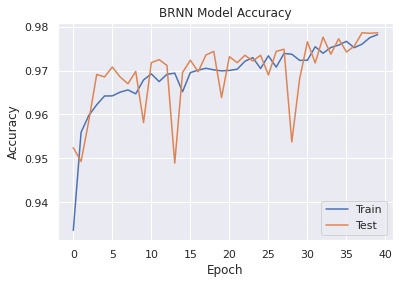

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('BRNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.savefig('BRNN Model Accuracy.png')
plt.show()

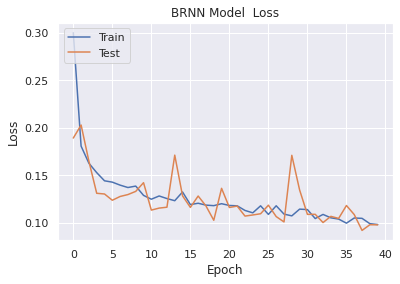

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('BRNN Model  Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('BRNN Model Loss.png')
plt.show()

In [28]:
predict = model.predict(X_test, verbose=1)

625/625 [==============================] - 3s 4ms/step


In [29]:
tp = 0
tn = 0
fp = 0
fn = 0
predictn = predict.flatten().round()
predictn = predictn.tolist()
Y_testn = Y_test.tolist()
for i in range(len(Y_testn)):
  if predictn[i]==1 and Y_testn[i]==1:
    tp+=1
  elif predictn[i]==0 and Y_testn[i]==0:
    tn+=1
  elif predictn[i]==0 and Y_testn[i]==1:
    fp+=1
  elif predictn[i]==1 and Y_testn[i]==0:
    fn+=1


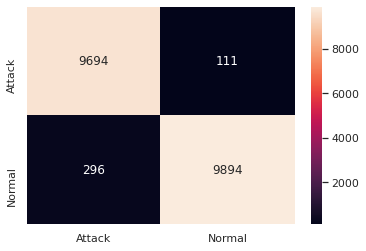

In [30]:
to_heat_map =[[tn,fp],[fn,tp]]
to_heat_map = pd.DataFrame(to_heat_map, index = ["Attack","Normal"],columns = ["Attack","Normal"])
ax = sns.heatmap(to_heat_map,annot=True, fmt="d")

In [31]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 97.96%


In [33]:
from sklearn.metrics import classification_report
target_names = ['attack', 'normal']
print(classification_report(Y_testn, predictn, target_names=target_names))

              precision    recall  f1-score   support

      attack       0.99      0.97      0.98      9990
      normal       0.97      0.99      0.98     10005

    accuracy                           0.98     19995
   macro avg       0.98      0.98      0.98     19995
weighted avg       0.98      0.98      0.98     19995

